In [1]:
import datetime
import os
import re
from collections import Counter
from datetime import datetime, timedelta

import numpy as np
from keras.preprocessing import sequence
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn

import sys
sys.path.append('../')
from ftw_model.extract_feature import computing_feature_wo

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.read_csv('../hh_dataset/hh102/hh102.rawdata.txt', sep='\t')

,2011-06-15 00:06:32.834414,M021,Bedroom,Bed,ON,Control4-Motion
0,2011-06-15 00:06:33.988964,M021,Bedroom,Bed,OFF,Control4-Motion
1,2011-06-15 00:15:01.957718,LS013,Ignore,Ignore,6,Control4-LightSensor
2,2011-06-15 00:25:01.892474,LS013,Ignore,Ignore,7,Control4-LightSensor
3,2011-06-15 03:37:46.585185,M021,Bedroom,Bed,ON,Control4-Motion
4,2011-06-15 03:37:47.706265,M021,Bedroom,Bed,OFF,Control4-Motion
...,...,...,...,...,...,...
6472390,2014-04-16 14:32:23.576643,M015,WorkArea,WorkArea,ON,Control4-Motion
6472391,2014-04-16 14:32:24.689070,M015,WorkArea,WorkArea,OFF,Control4-Motion
6472392,2014-04-16 14:32:34.595843,M015,WorkArea,WorkArea,ON,Control4-Motion
6472393,2014-04-16 14:32:36.488970,M015,WorkArea,WorkArea,OFF,Control4-Motion


## Define activities mapping and FTW details

In [3]:
activity_mapping = {
                              "Cook_Breakfast": "Cook",
                              "Cook_Lunch": "Cook",
                              "Cook_Dinner": "Cook",
                              "Eat_Breakfast": "Eat",
                              "Eat_Lunch": "Eat",
                              "Eat_Dinner": "Eat",
                              "Morning_Meds": "Take_Medicine",
                              "Evening_Meds": "Take_Medicine",
                              "Wash_Breakfast_Dishes": "Wash_Dishes",
                              "Wash_Lunch_Dishes": "Wash_Dishes",
                              "Wash_Dinner_Dishes": "Wash_Dishes",
                              "Work_At_Table": "Work",
                              "Watch_TV": "Relax",
                              "Read": "Work",
                              "Entertain_Guests": "Relax",
                              "Sleep_Out_Of_Bed": "Relax",
                              "Step_Out": "Leave_Home",
                     }
FTWs = [720, 540, 360, 180, 60, 30, 15, 5, 3, 2, 1, 0, 0]
# FTWs = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144][::-1]
ftw_window = 10

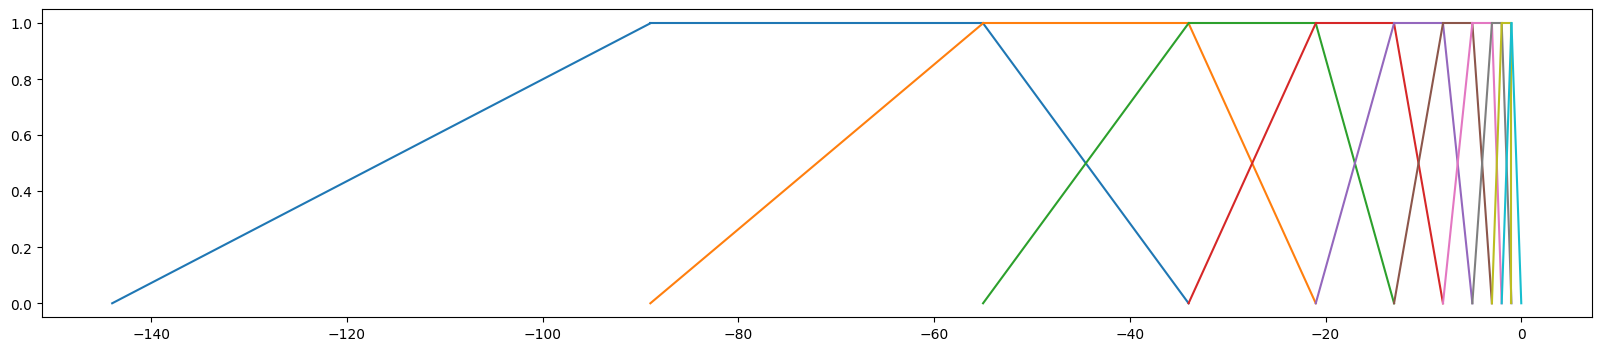

In [27]:
%matplotlib inline

n = 10
fig = plt.figure(figsize=(20, 4))
color = sns.color_palette().as_hex()
for i in range(n):
    c = color[i]
    l4, l3, l2, l1 = FTWs[i:i+4]
    plt.plot((-l4, -l3), (0, 1), c=c)
    plt.plot((-l3, -l2), (1, 1), c=c)
    plt.plot((-l2, -l1), (1, 0), c=c)
plt.show()

In [4]:
def read_hh_dataset(dataset_path):

    ann_dataset = pd.read_csv(dataset_path, sep='\t')

    raw_columns = ['Date & Time', 'Sensor ID', 'Room-level', 'Sensor location', 'Message', 'Sensor Type']
    ann_columns = raw_columns + ['Activity']

    ann_dataset.columns = ann_columns
    ann_dataset['Activity'] = ann_dataset['Activity'].apply(lambda x: activity_mapping[x] if x in activity_mapping else x)

    ann_dataset['Date & Time'] = pd.to_datetime(ann_dataset['Date & Time'], format='%Y-%m-%d %H:%M:%S')
    start_time, end_time = ann_dataset['Date & Time'].min(), ann_dataset['Date & Time'].max()
    timeframed_dataset = ann_dataset.set_index(['Date & Time'])

    activity2id = {}
    count = 0
    for act in ann_dataset['Activity'].unique():
        if act != 'Other_Activity':
            activity2id[act] = count
            count += 1
    activity2id['Other_Activity'] = count
    
    return timeframed_dataset, start_time, end_time, activity2id

In [5]:
hh_dataset = [f'hh1{str(i) if i >=10 else "0"+str(i)}' for i in range(1, 31)]
# activity = set()
# total_data = 0
# for file in hh_dataset:
#     if file == 'hh121':
#         continue
#     ann_dataset, start, end, activity2id = read_hh_dataset(f'../hh_dataset/{file}/{file}.ann.txt')
#     total_data += len(ann_dataset[ann_dataset['Activity'] != 'Other_Activity'])
#     activity = activity.union(activity2id)
# # activity
# total_data

In [6]:
file = 'hh102'
timeframed_dataset, start_time, end_time, activity2id = read_hh_dataset(f'../hh_dataset/{file}/{file}.ann.txt')

In [7]:
activity2id = {}
count = 0
for act in timeframed_dataset['Activity'].unique():
    if act != 'Other_Activity':
        activity2id[act] = count
        count += 1
activity2id['Other_Activity'] = count
activity2id

{'Sleep': 0,
 'Bed_Toilet_Transition': 1,
 'Toilet': 2,
 'Take_Medicine': 3,
 'Dress': 4,
 'Work': 5,
 'Cook': 6,
 'Eat': 7,
 'Wash_Dishes': 8,
 'Relax': 9,
 'Personal_Hygiene': 10,
 'Bathe': 11,
 'Groom': 12,
 'Drink': 13,
 'Leave_Home': 14,
 'Enter_Home': 15,
 'Phone': 16,
 'Other_Activity': 17}

In [8]:
delta = timedelta(days=1)
number_of_days = int(np.ceil((end_time - start_time) / delta))

df_activities = [[] for _ in range(len(activity2id))]

# activities = np.zeros((number_of_days, len(activity2id)-1))
for i in range(number_of_days):
    activity_within_range = timeframed_dataset[start_time+i*delta: start_time+(i+1)*delta]
    # activity_within_range['time'] = activity_within_range.index.time
    # activity_within_range.set_index(activity_within_range['time'], inplace=True)
    for i, act in enumerate(activity2id):
        df_activities[i].append(activity_within_range[activity_within_range['Activity'] == act])

Dress


<AxesSubplot:>

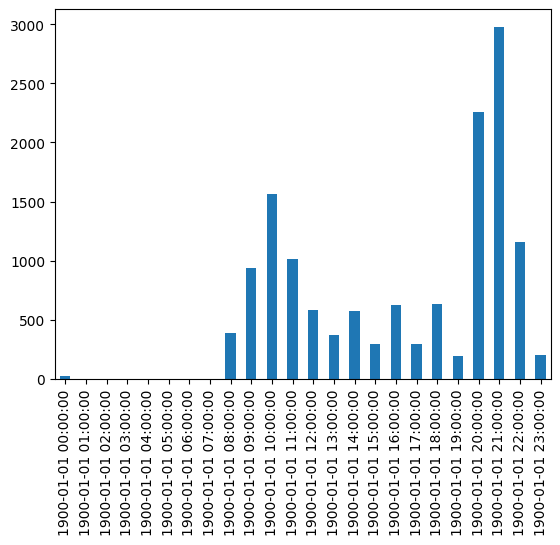

In [9]:
choice = 4
print(list(activity2id.keys())[choice])
testing = pd.concat(df_activities[choice]).sort_index()
# testing.groupby(testing.index.hour).count()
# pd.to_datetime(testing['time'], format='%X')
# testing['Activity'].groupby(pd.Grouper(freq='H')).count()
testing['time'] = testing.index
testing['time'] = testing['time'].apply(lambda dt: dt.replace(day=1).replace(month=1).replace(year=1900))
testing.set_index(testing['time'], inplace=True)

f= lambda x: x.reindex(pd.date_range(x.index.min().floor('d'),
                                      x.index.min().floor('d')+pd.Timedelta(23, 'H'),freq='H'))
x = testing.groupby(pd.Grouper(freq='H')).count()
f(x)['Activity'].plot(kind='bar')

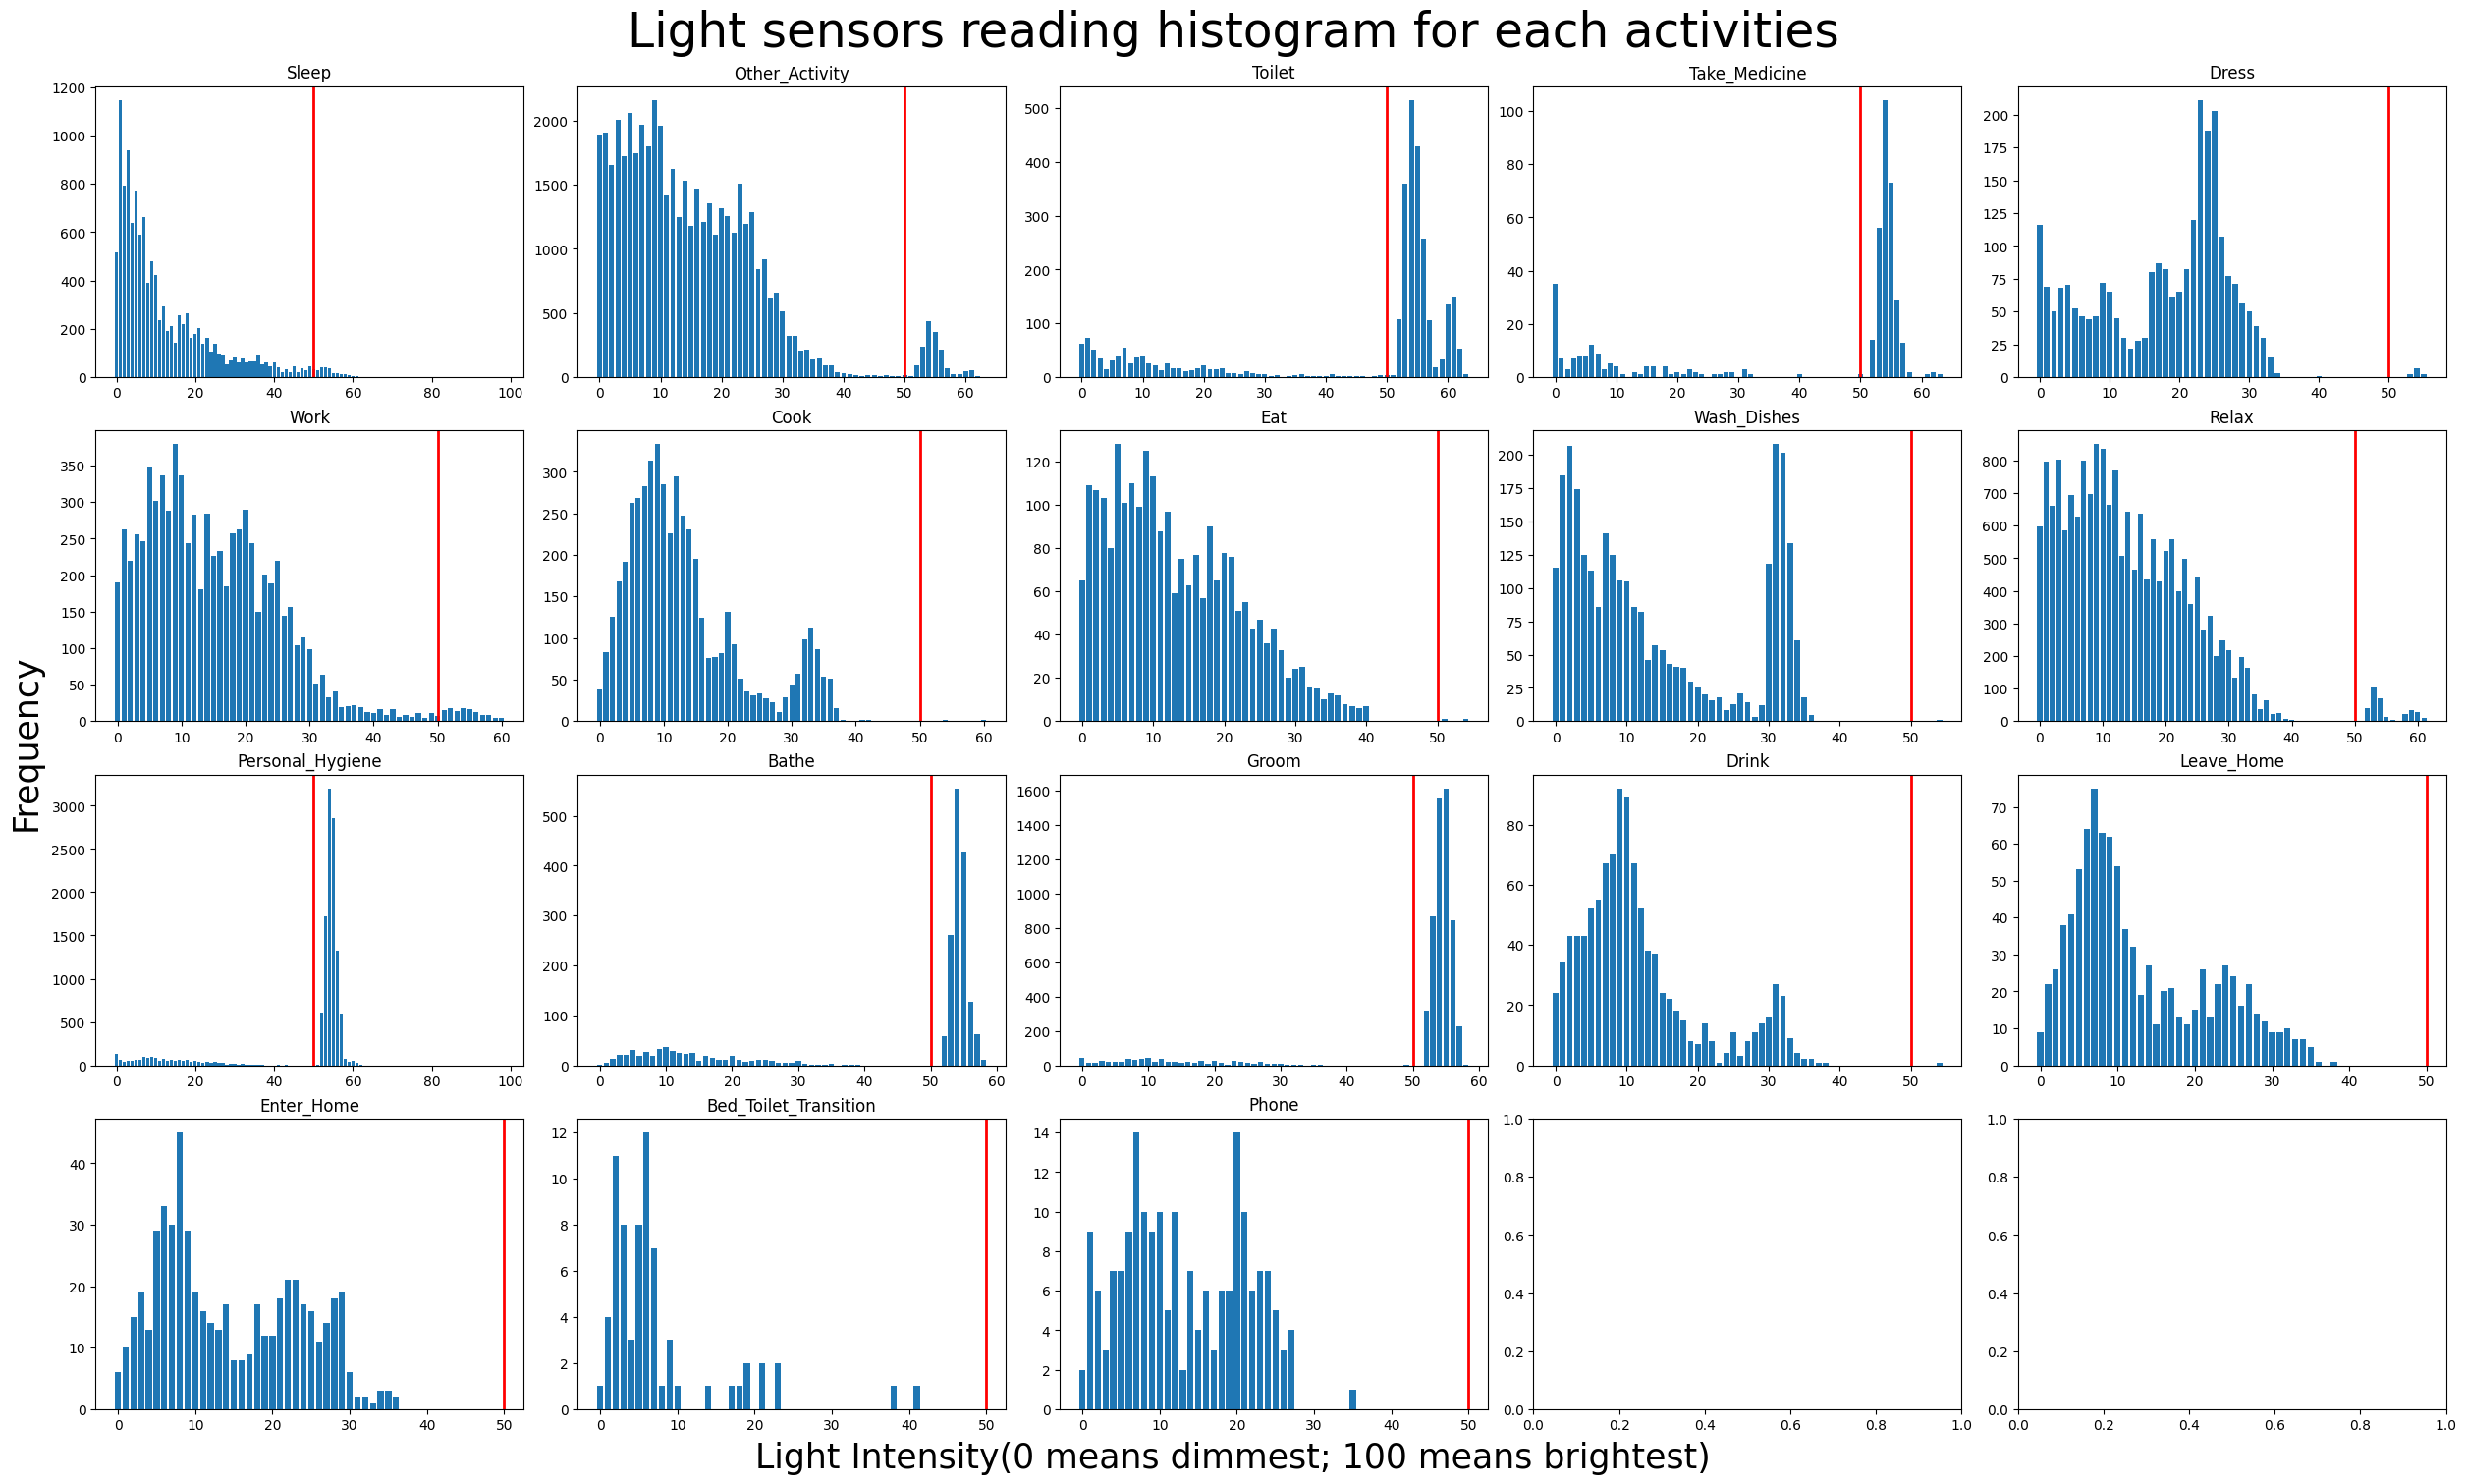

In [10]:
light_sensor_df = timeframed_dataset[timeframed_dataset['Sensor ID'].apply(lambda x : x[0:2] == "LS")]

light_sensor_activity_list = list(light_sensor_df['Activity'].unique())

fig, axs = plt.subplots(4, 5, figsize=(25, 15), constrained_layout=True)
for i, act in enumerate(light_sensor_activity_list):
    act_light_readings = light_sensor_df[light_sensor_df['Activity'] == act]['Message']

    counter = {int(k): v for k, v in Counter(act_light_readings).items()}
    axs[i//5][i % 5].bar(counter.keys(), counter.values())
    axs[i//5][i % 5].axvline(x=50, linewidth=2, color='r')
    axs[i//5][i % 5].title.set_text(act)
# plt.xlabel("common X")
# plt.ylabel("common Y")
# plt.show()

fig.suptitle('Light sensors reading histogram for each activities', size=35)
fig.supxlabel('Light Intensity(0 means dimmest; 100 means brightest)', size=25)
fig.supylabel('Frequency', size=25)
plt.savefig('./figure/light_sensor_reading_plot.png', dpi=150, bbox_inches="tight")

In [9]:
Counter(light_sensor_df['Sensor ID'])

Counter({'LS013': 23039,
         'LS006': 6111,
         'LS010': 4919,
         'LS003': 7561,
         'LS004': 5525,
         'LS005': 6537,
         'LS015': 3772,
         'LS002': 4042,
         'LS014': 5675,
         'LS022': 2984,
         'LS016': 3872,
         'LS008': 8683,
         'LS007': 7048,
         'LS001': 3940,
         'LS020': 7118,
         'LS011': 3727,
         'LS017': 4086,
         'LS012': 3343,
         'LS021': 3181,
         'LS019': 2815,
         'LS018': 4107,
         'LS009': 1562,
         'LS023': 949})

In [10]:
Counter(light_sensor_df[light_sensor_df['Message'].apply(lambda x : int(x) > 50)]['Sensor ID'])

Counter({'LS006': 132,
         'LS003': 112,
         'LS013': 21048,
         'LS009': 724,
         'LS010': 49,
         'LS004': 50,
         'LS005': 28,
         'LS019': 1,
         'LS014': 11,
         'LS008': 3})

In [11]:
timeframed_dataset[(timeframed_dataset['Sensor Type'] == 'Control4-Light') & (timeframed_dataset['Activity'] != 'Other_Activity')]['Room-level'].unique()

array(['Bathroom', 'Bedroom', 'WorkArea', 'OutsideDoor'], dtype=object)

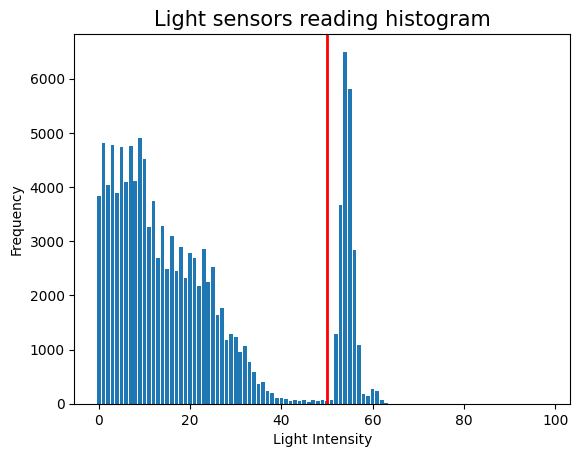

In [12]:
# Plot the Light sensor reading distribution
counter = Counter(timeframed_dataset[timeframed_dataset['Sensor ID'].apply(lambda x : x[:2] == "LS")]['Message'])


counter = {int(k): v for k, v in counter.items()}
plt.bar(counter.keys(), counter.values())
plt.axvline(x=50, linewidth=2, color='r')

plt.xlabel('Light Intensity', size=10)
plt.ylabel('Frequency', size=10)
plt.title('Light sensors reading histogram', size=15)
plt.show()

# Compute the activity input

In [12]:
## TODO reduce the time delta and compute the result between different time window

delta = timedelta(minutes=2)

number_of_time_window = int(np.ceil((end_time - start_time) / delta))
activities = np.zeros((number_of_time_window, len(activity2id)-1))
# timeframed_dataset[start_time: start_time+delta]
for i in range(number_of_time_window):
    activity_within_range = timeframed_dataset[start_time+i*delta: start_time+(i+1)*delta]['Activity'].unique()
    for j in activity_within_range:
        if j == "Other_Activity":
            continue
        else:
            activities[i][activity2id[j]] = 1

In [13]:
def get_time_window(offset):
    return timeframed_dataset[start_time+offset*delta: start_time+(offset+1)*delta]

## Compute the feature vector

In [14]:
sensors_list = list(filter(lambda x : x[0] != 'T' , timeframed_dataset['Sensor ID'].unique()))
sensors_list
sensor2id = {sensor: i for i , sensor in enumerate(sensors_list)}

In [15]:
def is_triggered_sensor(tup):
    timestamp, sensor, message = tup
    if message in ['ON', 'OPEN']:
        return timestamp, sensor2id[sensor]
    try:
        if int(message) >=50:
            return timestamp, sensor2id[sensor]
    except:
        pass
    return timestamp, -1

In [16]:
def compute_sensor_activation(start_time, end_time, weight):
    sensor_activation = np.zeros(len(sensors_list))
    sensors_detail = list(timeframed_dataset[start_time: end_time][['Sensor ID', 'Message']].itertuples(name=None))
    # print(sensors_detail)
    for j in sensors_detail:
        timestamp, sensor_triggered = is_triggered_sensor(j)
        if sensor_triggered > -1:
            if weight == 'flat':
                weight = 1
            elif weight == 'left':
                weight = (timestamp-start_time)/(end_time-start_time)
            elif weight == 'right':
                weight = (end_time-timestamp)/(end_time-start_time)
            sensor_activation[sensor_triggered] = weight
    return sensor_activation

In [17]:
ftw_testing = np.zeros((ftw_window, len(sensors_list)))
i = 10
testing = timeframed_dataset[start_time+i*delta: start_time+(i+1)*delta]
t_star = start_time+(i+1)*delta
for i in range(ftw_window):
    l4, l3, l2, l1 = FTWs[i:i+4]
    l4, l3, l2, l1 = timedelta(minutes=l4), timedelta(minutes=l3), timedelta(minutes=l2), timedelta(minutes=l1)

    left_slope = compute_sensor_activation(t_star-l2, t_star-l1, weight='left')
    flat_part = compute_sensor_activation(t_star-l3, t_star-l2, weight='flat')
    right_slope = compute_sensor_activation(t_star-l4, t_star-l3, weight='right')

    ftw_testing[i] = np.maximum(np.maximum(left_slope, flat_part), right_slope)
np.where(ftw_testing > 0)
ftw_testing.shape

(10, 56)

In [18]:
# ftw features (Shape: (number_of_time_window, ftw_window_size, no_sensors))
features = np.zeros((number_of_time_window, ftw_window, len(sensors_list)))
for i in trange(number_of_time_window):
    t_star = start_time+(i+1)*delta
    for j in range(ftw_window):
        l4, l3, l2, l1 = FTWs[j:j+4]
        l4, l3, l2, l1 = timedelta(minutes=l4), timedelta(minutes=l3), timedelta(minutes=l2), timedelta(minutes=l1)

        left_slope = compute_sensor_activation(t_star-l2, t_star-l1, weight='left')
        flat_part = compute_sensor_activation(t_star-l3, t_star-l2, weight='flat')
        right_slope = compute_sensor_activation(t_star-l4, t_star-l3, weight='right')

        features[i][j] = np.maximum(np.maximum(left_slope, flat_part), right_slope)



  1%|          | 436/44619 [00:04<07:52, 93.59it/s] 


KeyboardInterrupt: 

In [48]:
features.shape

(44619, 10, 56)

In [49]:
activities.shape

(44619, 17)

In [50]:
np.save('./ftw_data/fib_ftw_2mins_features.npy', features)
np.save('./ftw_data/fib_ftw_2mins_activities.npy', activities)

In [22]:
features = np.load('../hh_dataset/hh_npy/fib_hh102_feature.npy')
activities = np.load('../hh_dataset/hh_npy/fib_hh102_activity.npy')

## Scatter plot on the mismatched activities by previous LSTM model

Drink: shape(187, 10, 56)
Phone: shape(44, 10, 56)
Take_Medicine: shape(102, 10, 56)


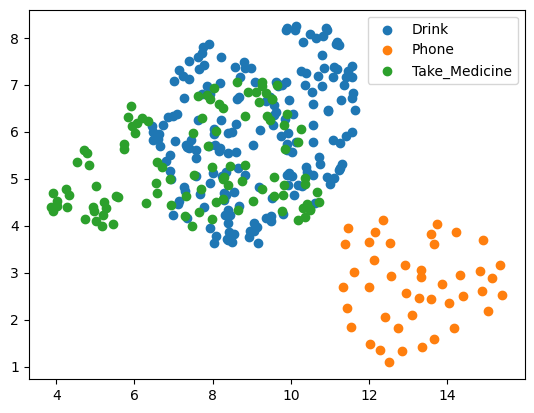

In [24]:
# Plotting the scatter plot
activities_plot = ['Drink', 'Phone', 'Take_Medicine']
for i, activity in enumerate(activities_plot):
    activity_vector = np.zeros(len(activity2id)-1)
    activity_index = [i for i, act in enumerate(activities) if (act[activity2id[activity]] == 1)]
    activity_feature_vector = np.array([feature for i, feature in enumerate(features) if i in activity_index])

    print(f'{activity}: shape{activity_feature_vector.shape}')
    instance, _, _ = activity_feature_vector.shape
    sleep_feature_vectors = activity_feature_vector.reshape((instance, -1))

    dim_reducer=umap.UMAP()
    scaled_data = StandardScaler().fit_transform(sleep_feature_vectors)
    embedding = dim_reducer.fit_transform(scaled_data)
    color_mapping = sns.color_palette("tab10", len(activities))

    plt.scatter(embedding[:, 0], embedding[:, 1], color=color_mapping[i], label=activity)
plt.legend()

Phone: shape(44, 10, 56)
Drink: shape(187, 10, 56)
Take_Medicine: shape(102, 10, 56)
Wash_Dishes: shape(210, 10, 56)
Toilet: shape(343, 10, 56)
Dress: shape(220, 10, 56)


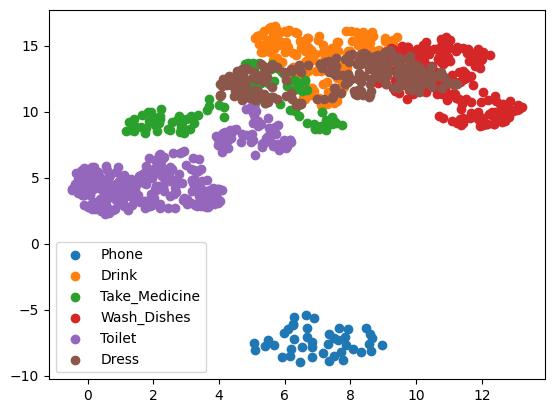

In [21]:
# Plotting the scatter plot
activities_plot = ['Phone', 'Drink', 'Take_Medicine', 'Wash_Dishes', 'Toilet', 'Dress']
for i, activity in enumerate(activities_plot):
    activity_vector = np.zeros(len(activity2id)-1)
    activity_index = [i for i, act in enumerate(activities) if (act[activity2id[activity]] == 1)]
    activity_feature_vector = np.array([feature for i, feature in enumerate(features) if i in activity_index])

    print(f'{activity}: shape{activity_feature_vector.shape}')
    instance, _, _ = activity_feature_vector.shape
    sleep_feature_vectors = activity_feature_vector.reshape((instance, -1))

    dim_reducer=umap.UMAP()
    scaled_data = StandardScaler().fit_transform(sleep_feature_vectors)
    embedding = dim_reducer.fit_transform(scaled_data)
    color_mapping = sns.color_palette("tab10", len(activities))

    plt.scatter(embedding[:, 0], embedding[:, 1], color=color_mapping[i], label=activity)
plt.legend()

In [18]:
instance, _, _ = features.shape
flatten_feature = features.reshape((instance, -1))
feature_counting_non_zero = [(i, np.count_nonzero(x > 0)) for i, x in enumerate(flatten_feature)]
act_counting_non_zero = [np.count_nonzero(x > 0) for i, x in enumerate(activities)]
np.argmax(act_counting_non_zero)
get_time_window(926)

,Sensor ID,Room-level,Sensor location,Message,Sensor Type,Activity
Date & Time,,,,,,
2011-06-27 20:46:34.244449,LS019,Ignore,Ignore,16,Control4-LightSensor,Dress
2011-06-27 20:46:34.305197,M019,Bedroom,Bedroom,ON,Control4-Motion,Dress
2011-06-27 20:46:38.335603,LS020,Ignore,Ignore,25,Control4-LightSensor,Dress
2011-06-27 20:46:38.391012,MA020,Bedroom,Bedroom,OFF,Control4-MotionArea,Dress
2011-06-27 20:46:39.302839,LS019,Ignore,Ignore,17,Control4-LightSensor,Dress
...,...,...,...,...,...,...
2011-06-27 20:59:36.078470,MA020,Bedroom,Bedroom,ON,Control4-MotionArea,Work
2011-06-27 20:59:37.059210,M021,Bedroom,Bed,OFF,Control4-Motion,Work
2011-06-27 20:59:38.837052,MA020,Bedroom,Bedroom,OFF,Control4-MotionArea,Work


## Agglomerative Clustering

In [19]:
# Simple group the activity base on the activities list
mean_act_feature_vector = {}

for activity in list(activity2id.keys())[:-1]:
    activity_vector = np.zeros(len(activity2id)-1)
    activity_index = [i for i, act in enumerate(activities) if (act[activity2id[activity]] == 1)]
    activity_feature_vector = np.array([feature for i, feature in enumerate(features) if i in activity_index])
    mean_act_feature_vector[activity] = np.mean(activity_feature_vector.reshape(len(activity_index), -1), axis=0)

len(mean_act_feature_vector['Sleep'])

560

Deep learning Feautres             |  Fuzzy Temporal Window
:-------------------------:|:-------------------------:
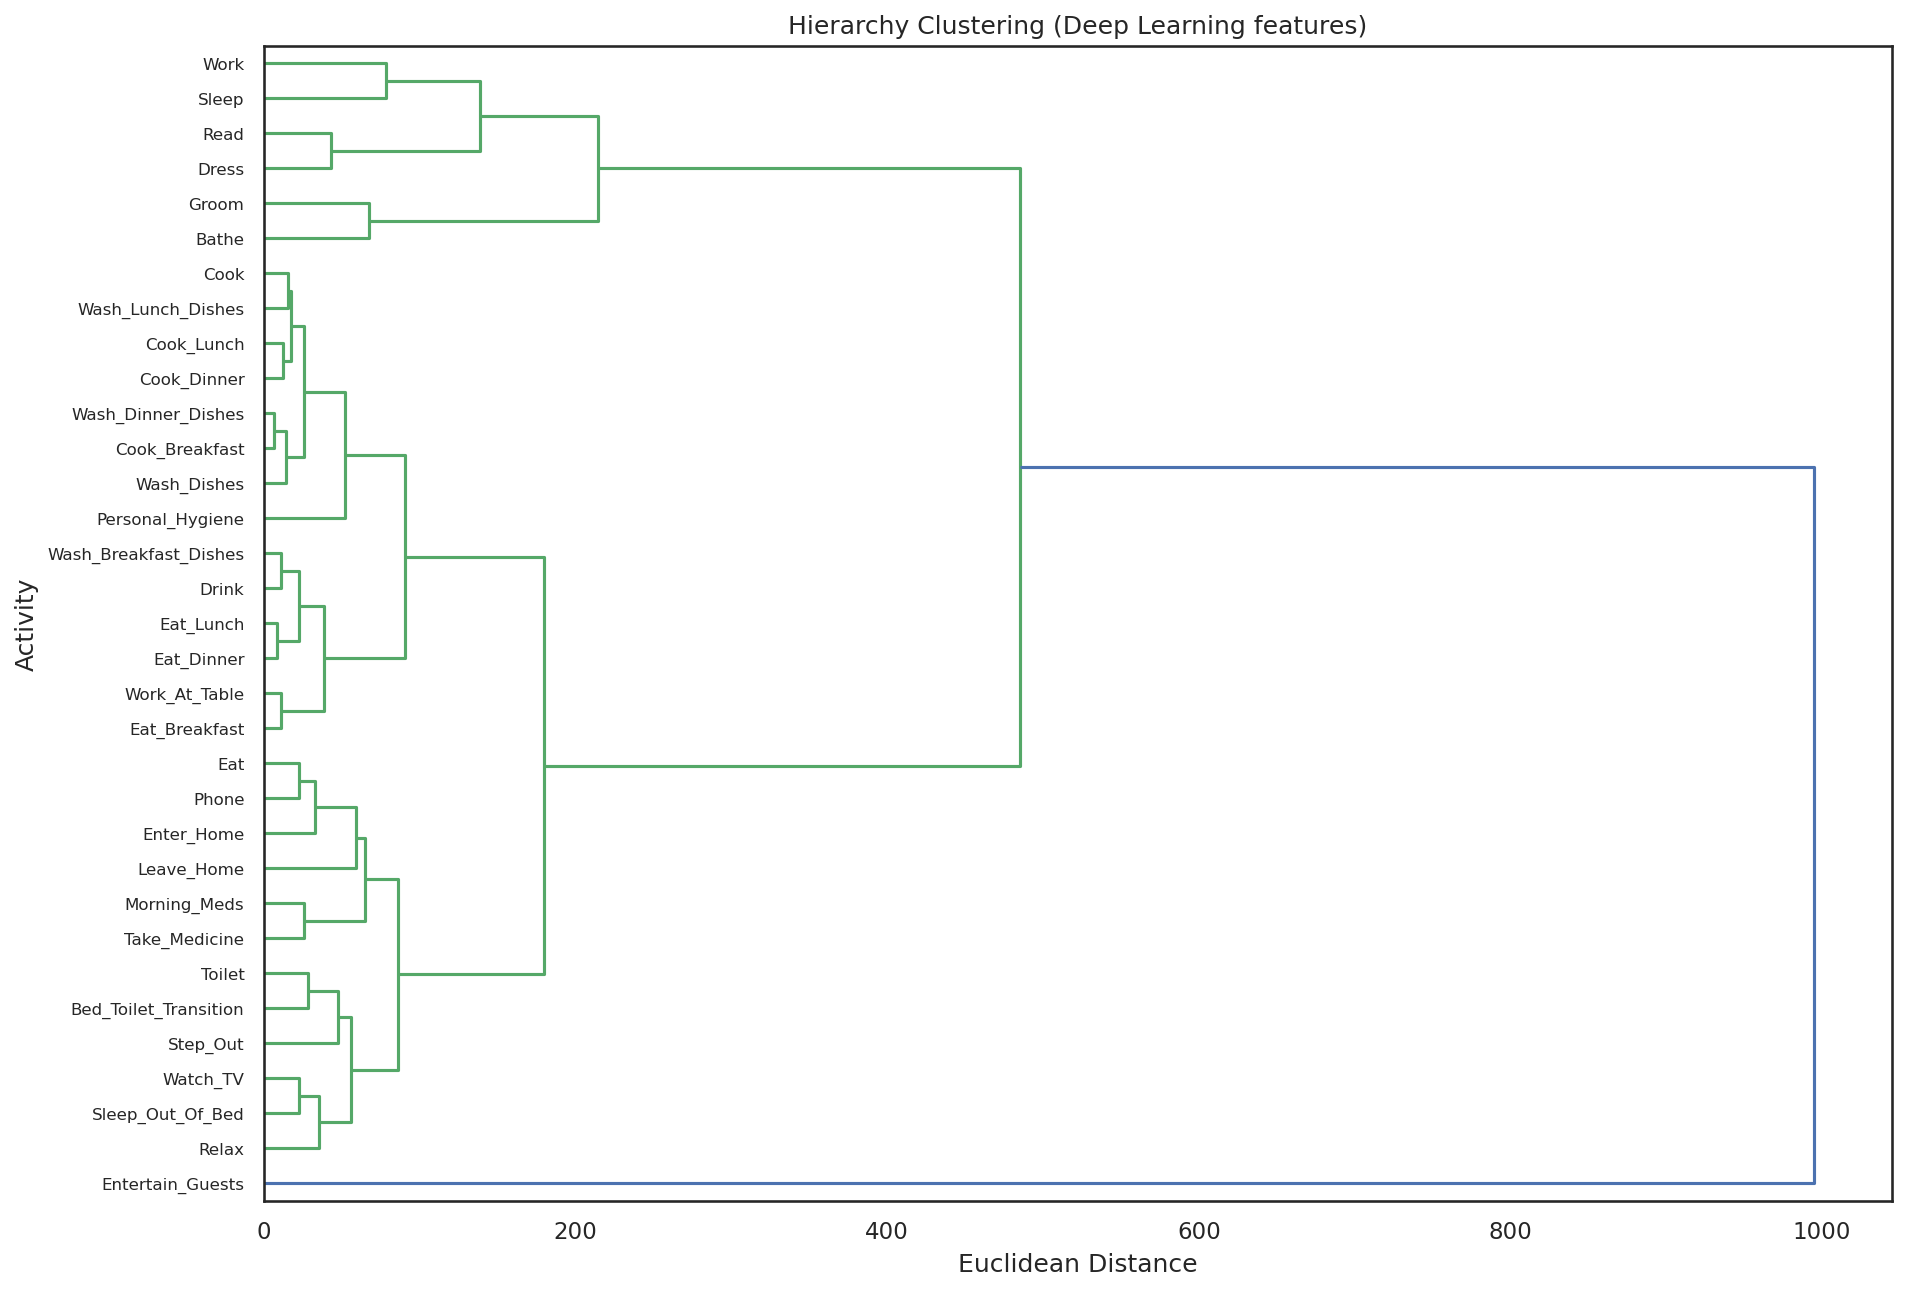 |  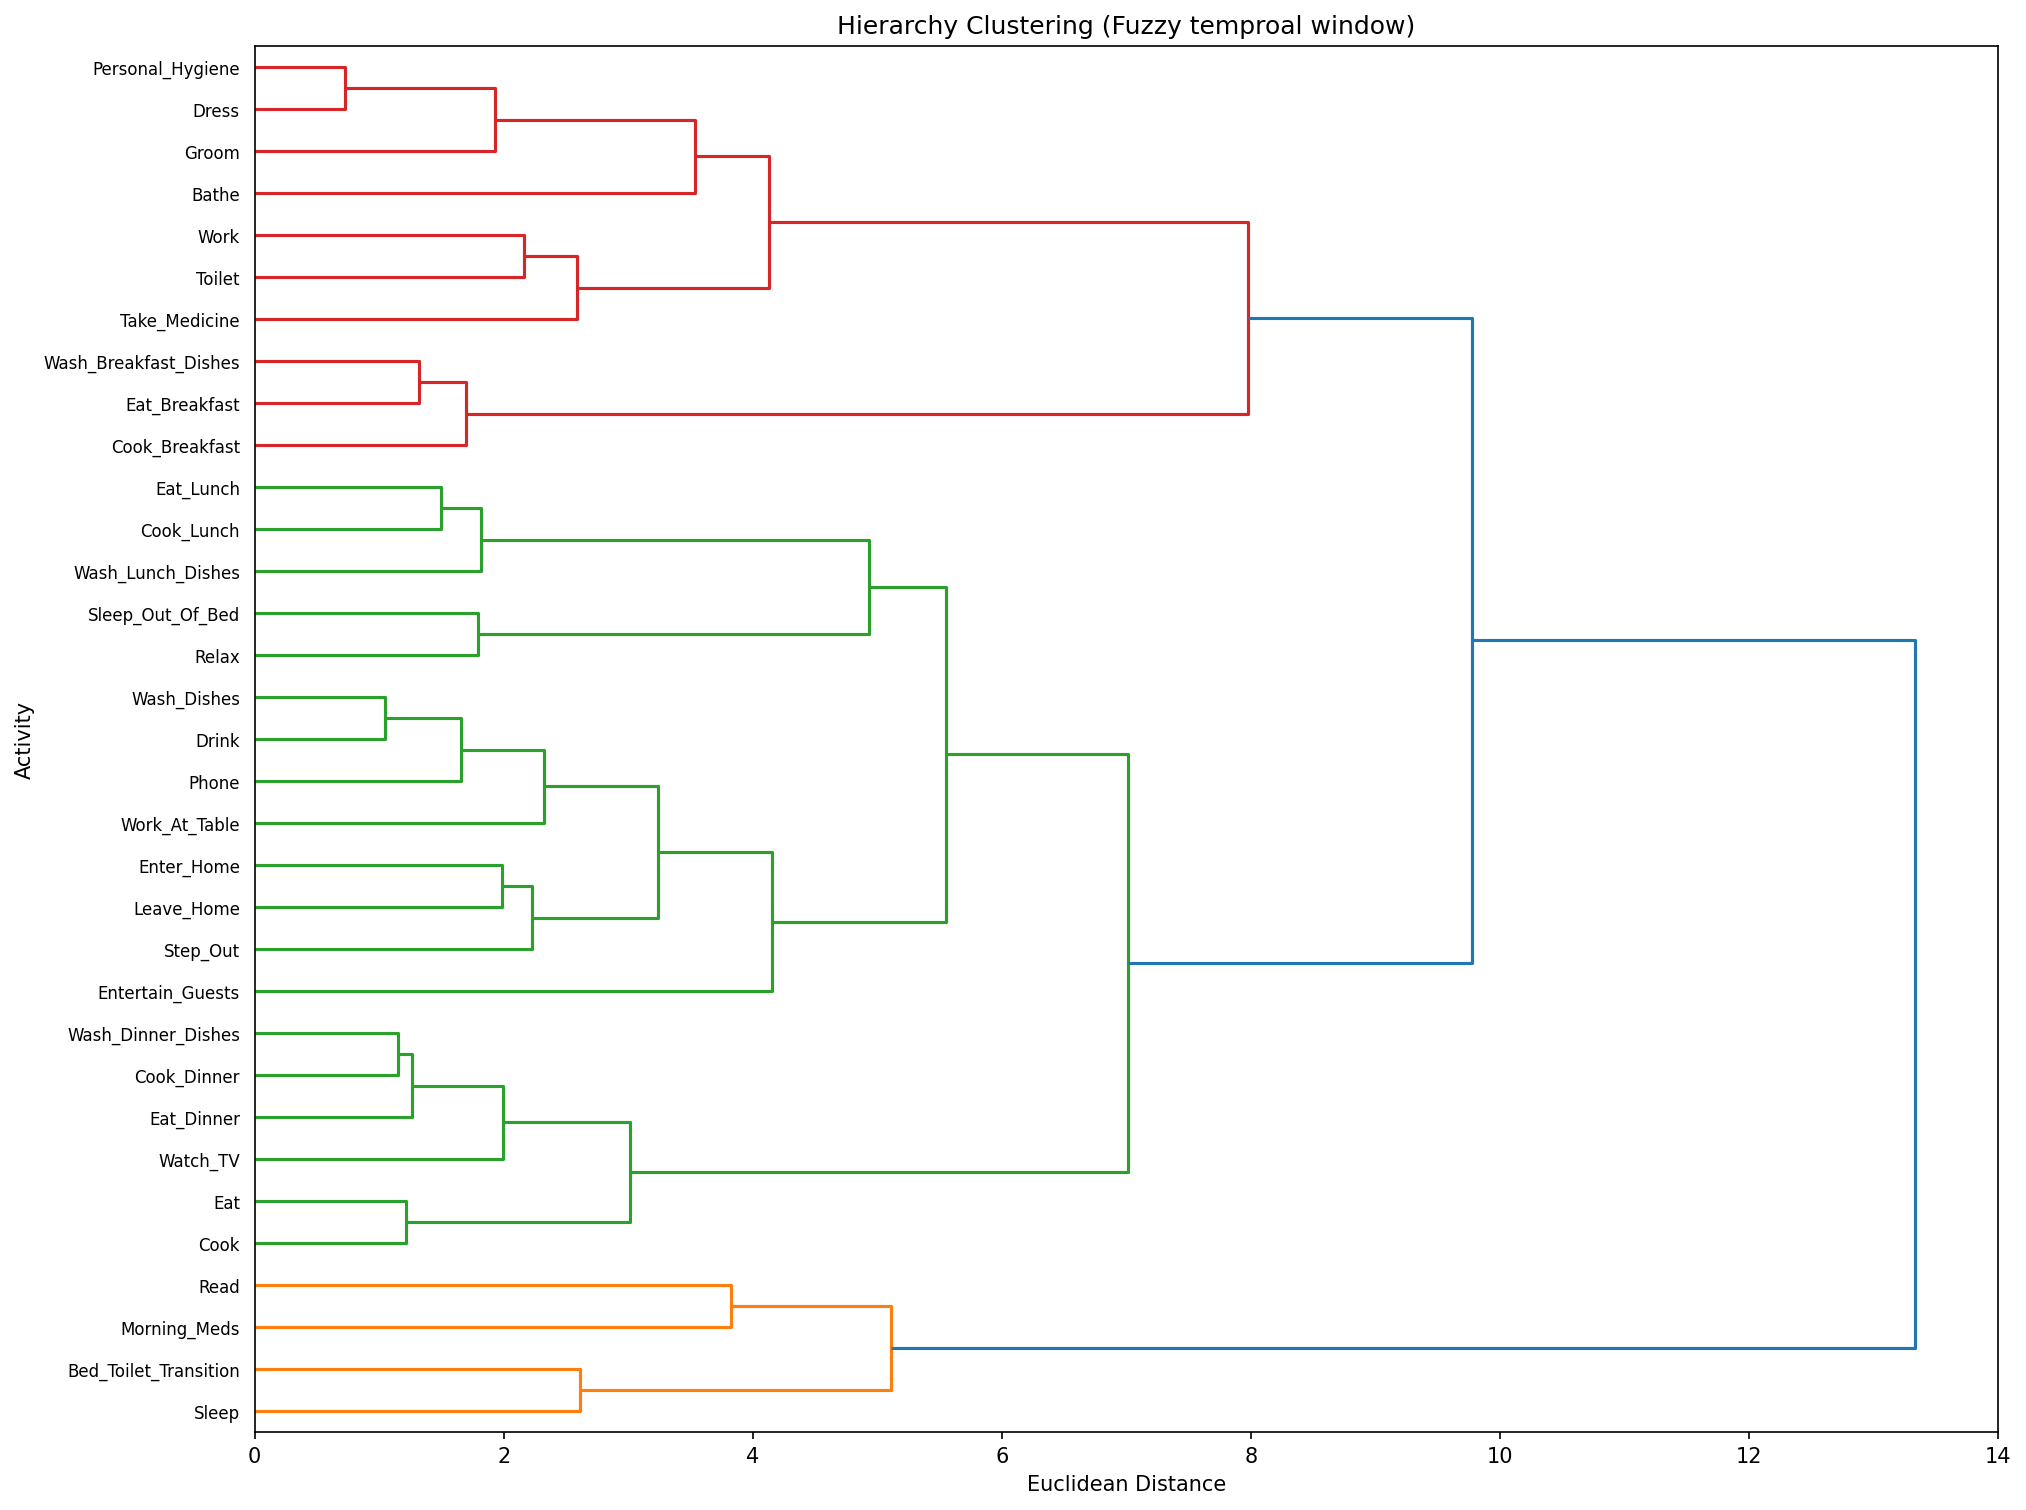

In [ ]:
# Agglomerative clustering on one-hot encoding data, focused on the sequence of sensors triggered
# manual_mapping=None
f, ax = plt.subplots(figsize=(15, 12))

labels = list(mean_act_feature_vector.keys())

linkage_data = linkage(list(mean_act_feature_vector.values()), method='ward', metric='euclidean')
dendrogram(linkage_data, labels=labels, orientation='right')

plt.ylabel('Activity')
plt.xlabel('Euclidean Distance')
plt.title('Hierarchy Clustering (Fuzzy temproal window)')
plt.savefig('./figure/feature_vector/hierarchy_clustering_after_mapping.png', dpi=150, bbox_inches="tight")
# plt.show()

Deep learning Feautres             |  Fuzzy Temporal Window
:-------------------------:|:-------------------------:
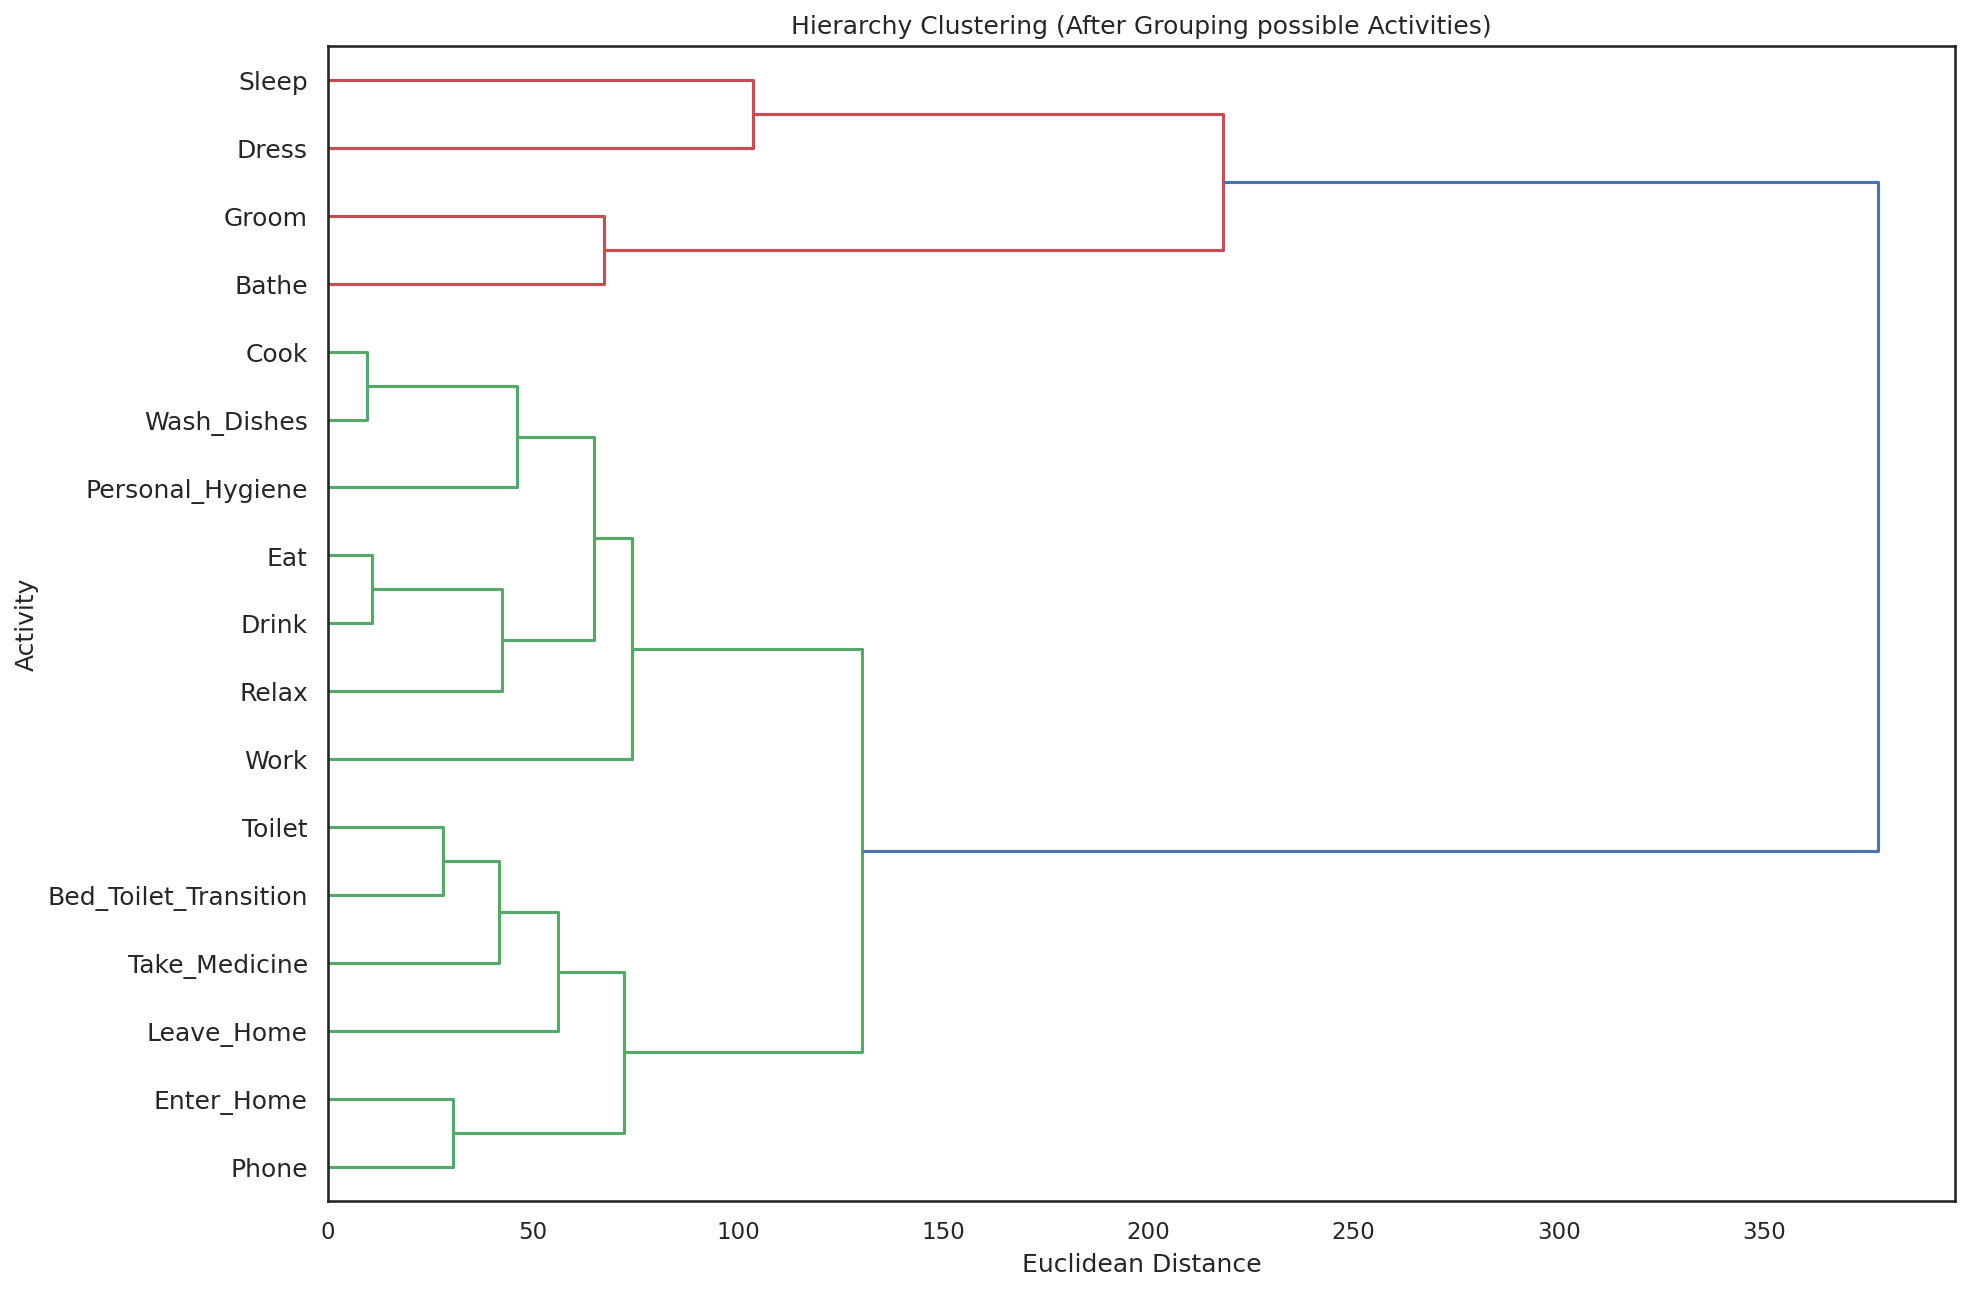 | 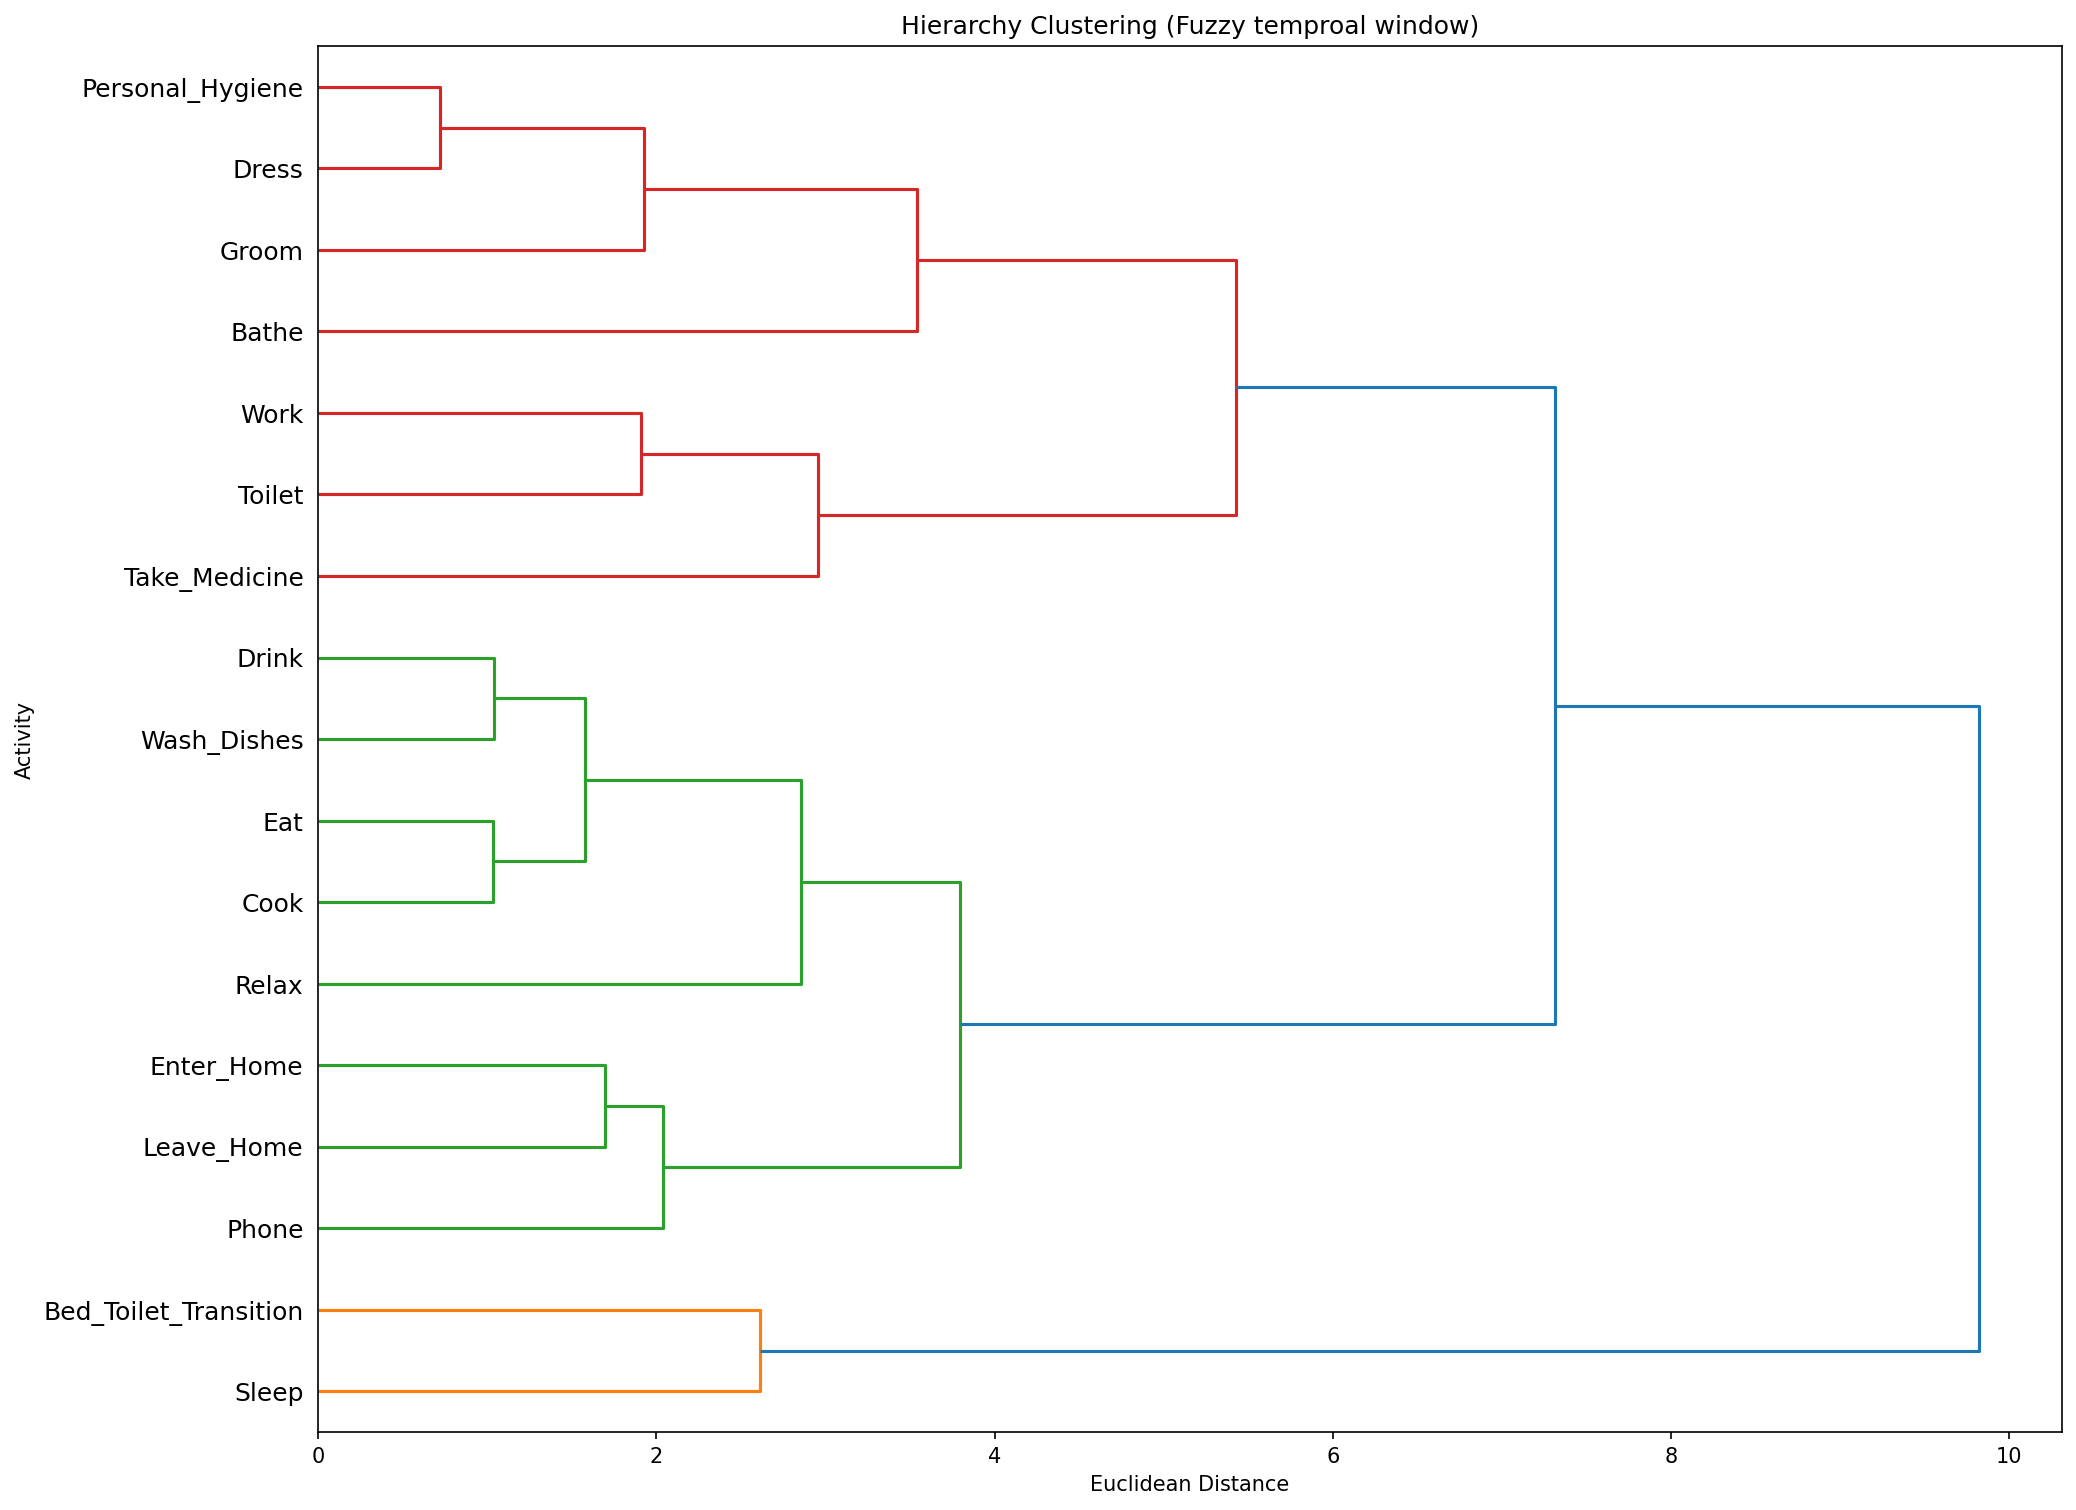

([<matplotlib.patches.Wedge at 0x7fcaac06a550>,
 [Text(0.8637395065399516, 0.681141736235654, 'Sleep'),
  Text(0.22105711582074442, 1.0775591638258264, 'Bed_Toilet_Transition'),
  Text(-0.043965687500593695, 1.0991210207809694, 'Toilet'),
  Text(-0.33723566775435604, 1.047030135380197, 'Take_Medicine'),
  Text(-0.5352045350344304, 0.9610182650077882, 'Dress'),
  Text(-0.9009923468826552, 0.6310410373809975, 'Work'),
  Text(-1.0914000627637594, 0.13728038096997683, 'Cook'),
  Text(-1.0819749189129624, -0.19831861950731883, 'Eat'),
  Text(-0.9917306604489743, -0.4758889546159288, 'Wash_Dishes'),
  Text(-0.43895064565263514, -1.0086239788350935, 'Relax'),
  Text(0.4731631948093875, -0.9930340331921026, 'Personal_Hygiene'),
  Text(0.7482017105207195, -0.8063462037945424, 'Bathe'),
  Text(0.8382208456807035, -0.7123101949757048, 'Groom'),
  Text(0.9628095401506288, -0.5319753654023229, 'Drink'),
  Text(1.0533201579259417, -0.3170436009555617, 'Leave_Home'),
  Text(1.0915668340689952, -0.135

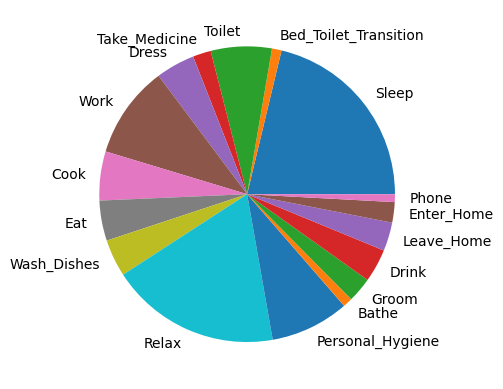

In [21]:
no_activities = list(map(lambda x : np.count_nonzero(x > 0), activities.T))

plt.pie(no_activities, labels=list(activity2id.keys())[:-1])

## Prepare for model training

In [12]:
# Splitting the data into training and validation
tsv = TimeSeriesSplit(n_splits=3)
X = features
Y = activities
for train, test in list(tsv.split(X, Y))[-1:]:
    X_train, Y_train, X_test, Y_test = X[train], Y[train], X[test], Y[test]

In [13]:
# Use simple model like random forest for classification

instance = X_train.shape[0]
X_train_reshaped = X_train.reshape((instance, -1))
instance = X_test.shape[0]
X_test_reshaped = X_test.reshape((instance, -1))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_reshaped)
X_test = scaler.transform(X_test_reshaped)

## Multiclass-multioutput Classification by Random Forest

In [14]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
# classification_report(Y_test, y_pred)

In [15]:
pd.DataFrame(classification_report(Y_test, y_pred, output_dict=True)).rename(columns={str(i): act for i, act in enumerate(list(activity2id.keys())[:-1])}).T

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Sleep,0.762821,0.668539,0.712575,178.0
Bed_Toilet_Transition,1.000000,0.545455,0.705882,11.0
Toilet,0.800000,0.111111,0.195122,72.0
Take_Medicine,1.000000,0.210526,0.347826,19.0
Dress,1.000000,0.044444,0.085106,45.0
Work,0.885714,0.254098,0.394904,122.0
Cook,1.000000,0.087719,0.161290,57.0
Eat,0.800000,0.111111,0.195122,36.0
Wash_Dishes,0.000000,0.000000,0.000000,37.0
Relax,0.803150,0.662338,0.725979,154.0


(3, 6)

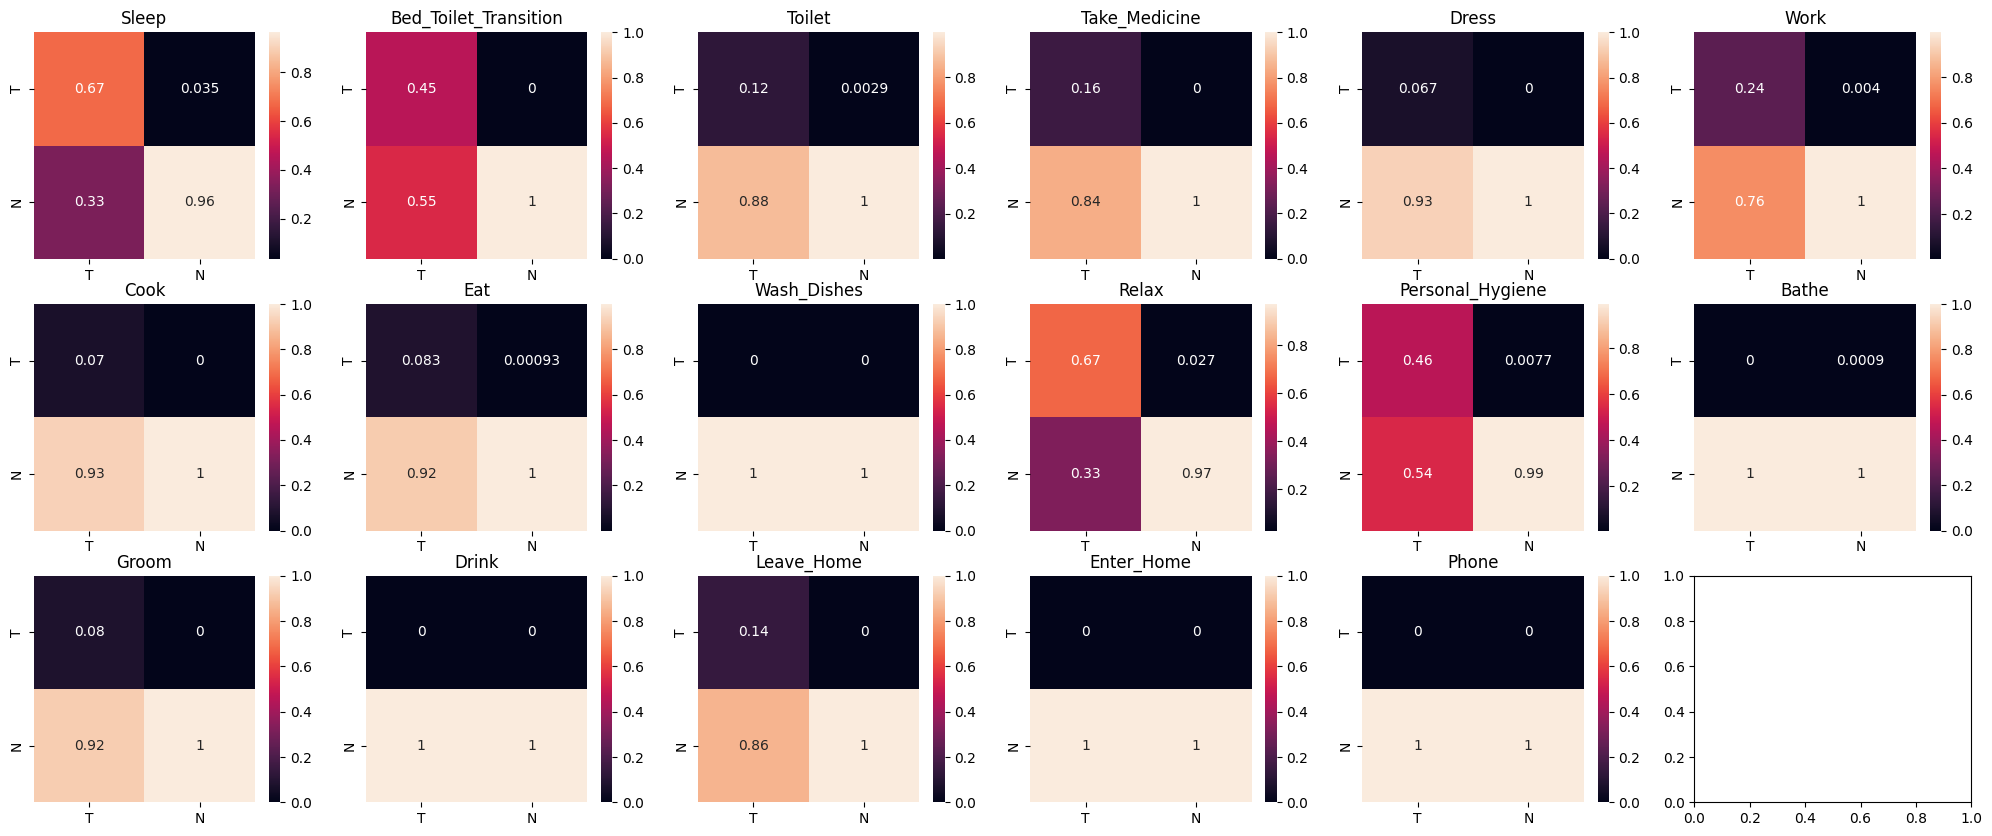

In [33]:
multi_confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(Y_test, y_pred)
fig, ax = plt.subplots(3, 6, figsize=(25, 10))
for i, act in enumerate(list(activity2id.keys())[:-1]):
    df_cm = pd.DataFrame(np.flip(multi_confusion_matrix[i]).T, index = [i for i in "TN"],
                  columns = [i for i in "TN"])
    df_cm = df_cm.apply(lambda x : x/x.sum() if x.sum() != 0 else x, axis=0)
    sns.heatmap(df_cm, annot=True, ax=ax[i//6][i%6])
    ax[i//6][i%6].title.set_text(act)
ax.shape

## Multiclass-single Classification by Random Forest

In [16]:
activity_count = dict(Counter(timeframed_dataset['Activity']))
del activity_count['Other_Activity']
act_sum = sum([v for k, v in activity_count.items()])
activity_weight = {k: 1/(v/act_sum) for k, v in activity_count.items()}
activity_weight
activities = np.zeros((number_of_time_window,))
# timeframed_dataset[start_time: start_time+delta]
## TODO!!!!! Add weights when finding the most frequent activity inside timewindow
for i in range(number_of_time_window):
    activity_within_range = timeframed_dataset[start_time+i*delta: start_time+(i+1)*delta]['Activity']
    time_window_activity_count = dict(Counter(activity_within_range[activity_within_range != 'Other_Activity']))
    most_common = [(k, v*activity_weight[k]) for k, v in time_window_activity_count.items()]
    
    if len(most_common) > 0:
        activities[i] = activity2id[max(most_common, key=lambda x:x[1])[0]]

{'Sleep': 16.05227839202403,
 'Bed_Toilet_Transition': 187.16095380029807,
 'Toilet': 19.14113702179546,
 'Take_Medicine': 114.7418912745546,
 'Dress': 17.846383402017903,
 'Work': 12.727779466909903,
 'Cook': 6.662687675738765,
 'Eat': 32.17240937620085,
 'Wash_Dishes': 13.367216604576901,
 'Relax': 7.444059156515811,
 'Personal_Hygiene': 5.585030685760029,
 'Bathe': 38.8627572334829,
 'Groom': 12.140267775146214,
 'Drink': 32.23848029777949,
 'Leave_Home': 58.83579292574374,
 'Enter_Home': 115.37436839687643,
 'Phone': 377.69924812030075}

In [36]:
# Splitting the data into training and validation
tsv = TimeSeriesSplit(n_splits=3)
X = features
Y = activities
for train, test in list(tsv.split(X, Y))[-1:]:
    X_train, Y_train, X_test, Y_test = X[train], Y[train], X[test], Y[test]

instance, _, _ = X_train.shape
X_train_reshaped = X_train.reshape((instance, -1))
instance, _ , _ = X_test.shape
X_test_reshaped = X_test.reshape((instance, -1))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_reshaped)
X_test = scaler.transform(X_test_reshaped)
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, Y_train)
y_pred = rfc.predict(X_test)
pd.DataFrame(classification_report(Y_test, y_pred, output_dict=True)).rename(columns={str(float(i)): act for i, act in enumerate(list(activity2id.keys())[:-1])}).T

,precision,recall,f1-score,support
Sleep,0.972549,0.984127,0.978304,756.000000
Bed_Toilet_Transition,0.888889,0.727273,0.800000,11.000000
Toilet,0.428571,0.150000,0.222222,20.000000
Take_Medicine,0.538462,0.388889,0.451613,18.000000
Dress,0.142857,0.062500,0.086957,16.000000
Work,0.750000,0.403846,0.525000,52.000000
Cook,0.290323,0.473684,0.360000,19.000000
Eat,0.476190,0.526316,0.500000,19.000000
Wash_Dishes,0.142857,0.052632,0.076923,19.000000
Relax,0.641509,0.829268,0.723404,82.000000


<AxesSubplot:>

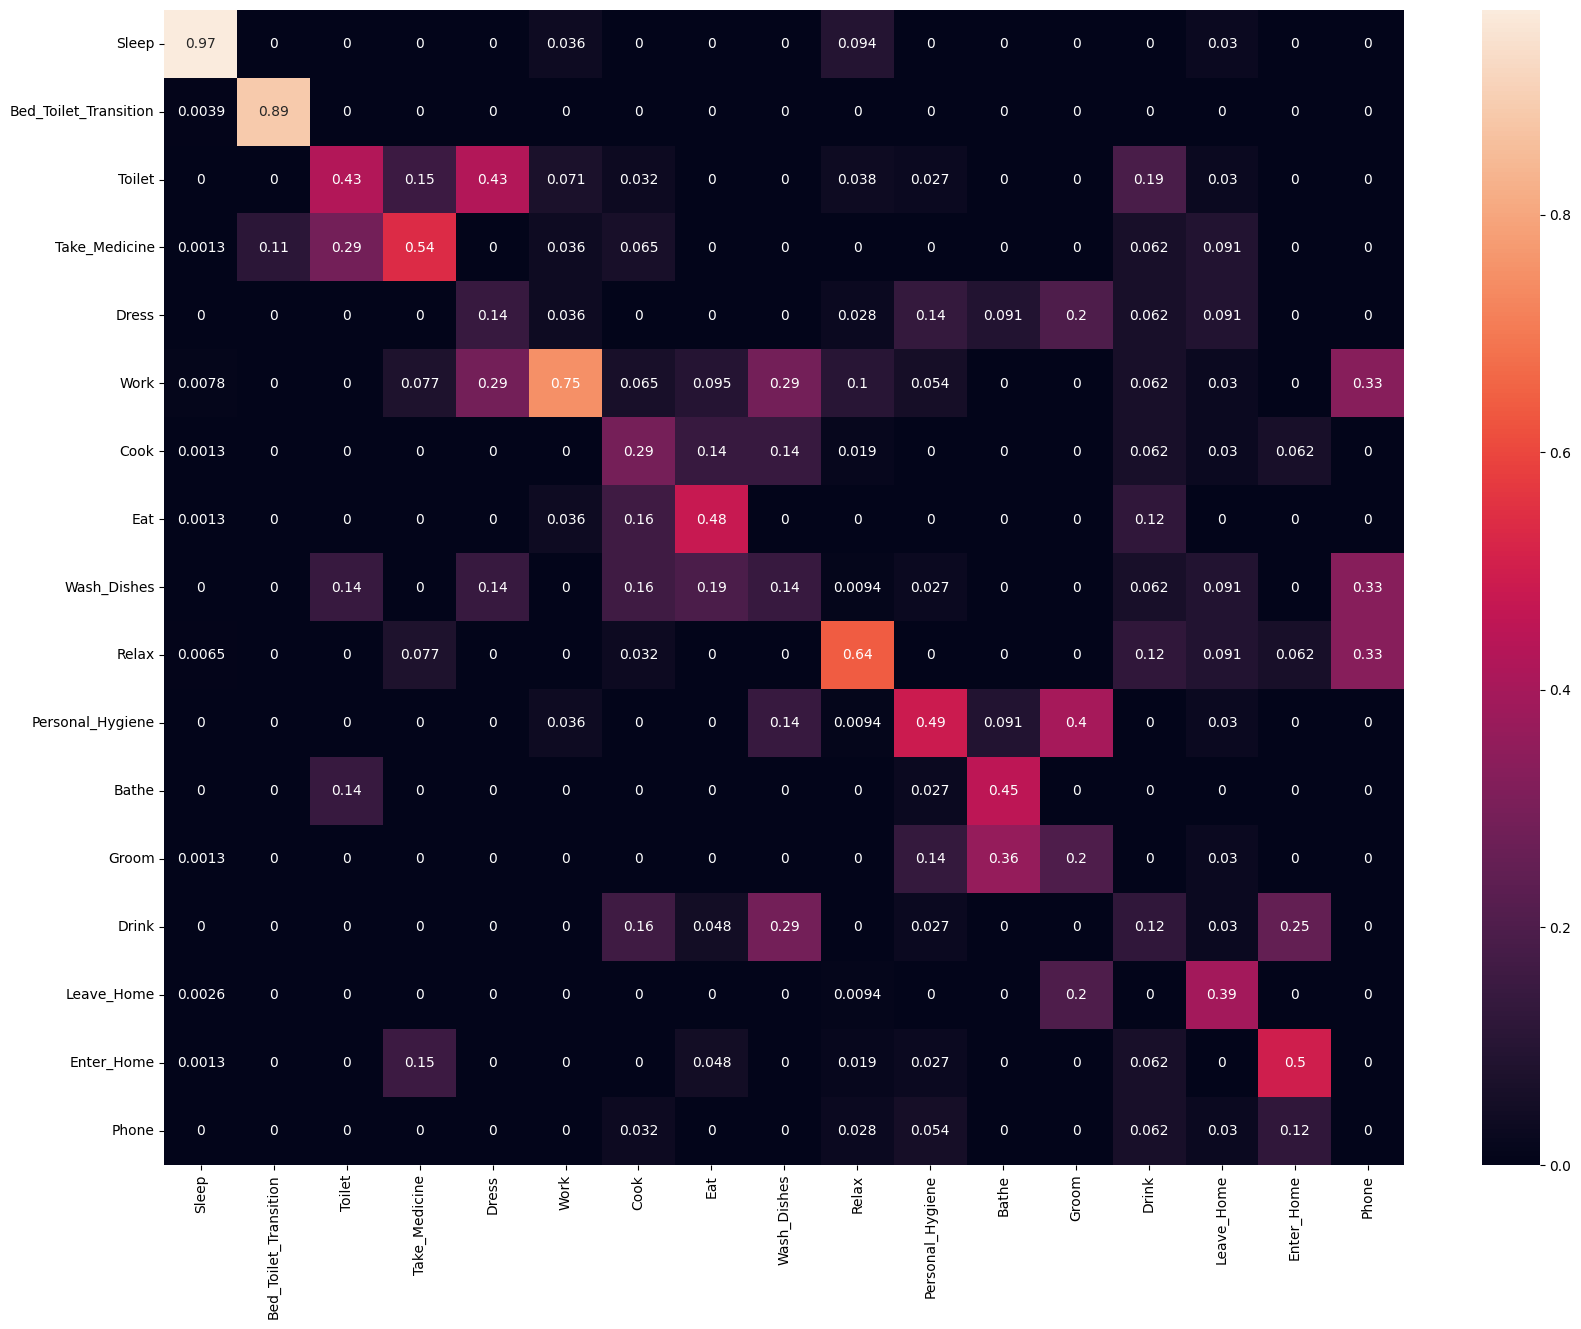

In [37]:
fig = plt.figure(figsize=(20, 15))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), index = list(activity2id.keys())[:-1],
              columns = list(activity2id.keys())[:-1])
df_cm = df_cm.apply(lambda x : x/x.sum() if x.sum() != 0 else x, axis=0)
sns.heatmap(df_cm, annot=True)

In [ ]:
# Ensemble PyTorch LSTM for classification